In [1]:
import netCDF4 as nc
from pathlib import Path
import glob

#Array 
import xarray as xr
import numpy as np
import datetime as dt
import pandas as pd
import dask

#Visualize
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import cmcrameri.cm as cmc # batlow colourmap

#large data visualization
import datashader as ds
from datashader import transfer_functions as tf, reductions as rd

# Analyse
from scipy import signal
from scipy.interpolate import BSpline

# Other
#import tqdm
import seaborn as sns

In [1]:
# IMPORT MAIN MODULE AND SUB-MODULES
import CL61_module
from CL61_module import module as mCL61
from CL61_module import classification

In [2]:
import importlib  # To reload files
importlib.reload(mCL61)
importlib.reload(classification)

<module 'CL61_module.classification' from 'c:\\Users\\gezas\\kDrive\\SIE-Project\\CL61\\CL61_module\\classification.py'>

In [3]:
plt.style.use('bmh')

COLOR_MAP = 'cmc.batlow'

NameError: name 'plt' is not defined

# Open dataset

In [5]:
februar  = mCL61.CL61Processor(folder_path='../CL61/Data', specific_filename='temp_20230204.nc')
june = mCL61.CL61Processor(folder_path='../CL61/Data', specific_filename='temp_1d_test.nc')

In [6]:
februar.mask_noise()
june.mask_noise()

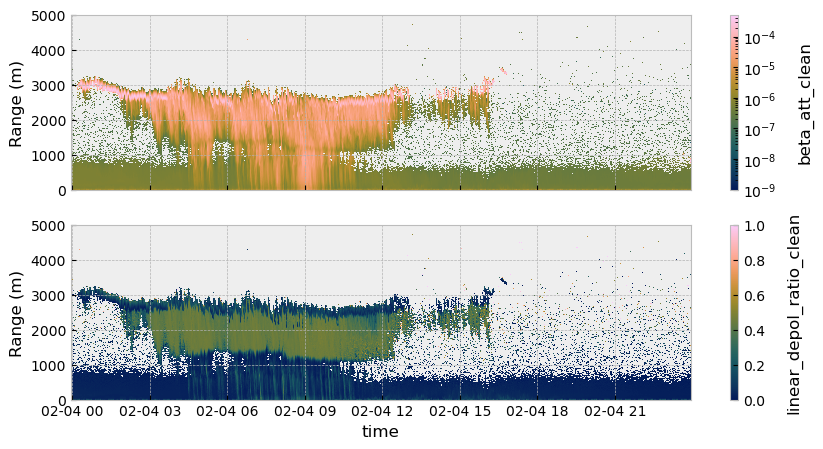

In [6]:
februar.visualize_data(plot_type='colormesh', varriable_names=['beta_att_clean', 'linear_depol_ratio_clean'])

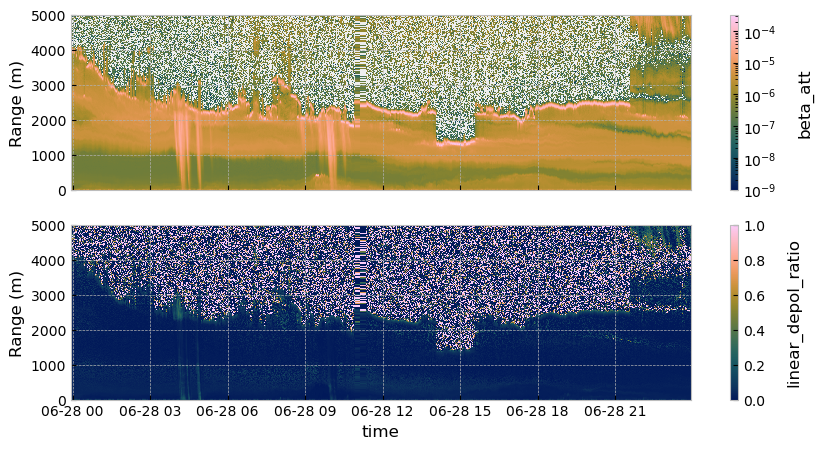

In [7]:
june.visualize_data(plot_type='colormesh')

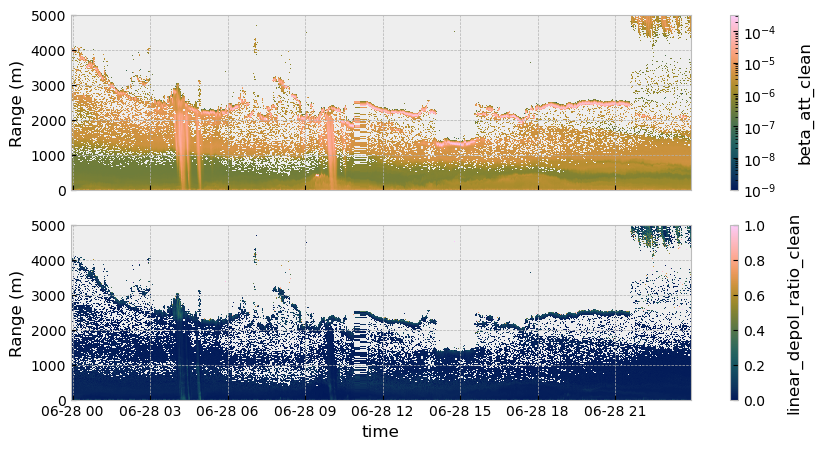

In [8]:
june.visualize_data(plot_type='colormesh', varriable_names=['beta_att_clean', 'linear_depol_ratio_clean'])

(4717440, 2)
Scaler means: [-5.78283455  0.17519691]  
 and scales: [0.82402228 0.17495366]


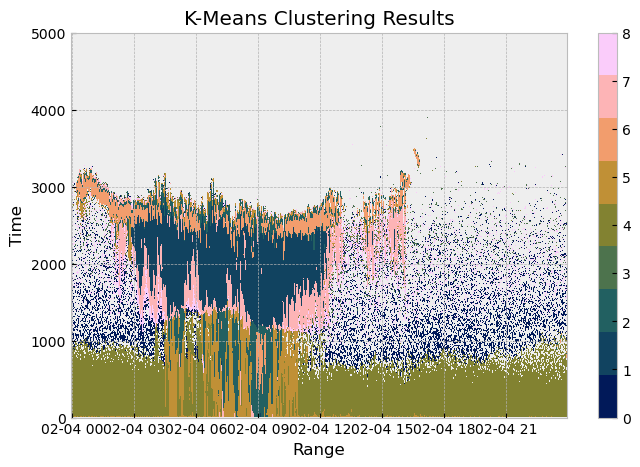

In [7]:
#Compute K-means
original_shape_labels_array = classification.K_means_classifier(februar.dataset,
                                                                 variable_as_features=['beta_att_clean', 'linear_depol_ratio_clean'], cluster_N=9)

In [29]:
depolarization_thresholds = {
    'liquid_droplets': [0,0.2],
    'smoke' : [0.02, 0.1],
    'dust' : [0.1, 0.2],
    'snow': [0.2, 0.4],
    'ice_crystals': [0.35, 1],
    'graupel':[0.4, 1]
}
beta_attenuation_thresholds = {
    'clear' : [1e-10, 1e-6],
    'low density':[1e-6, 5e-5],
    'couds':[5e-5, 1e-3],
}

In [32]:
# Create a mapping of class label combinations to numbers
class_combination_mapping_corrected = {
    'clear & clear': 0,
    'low density & liquid_droplets': 1,
    'low density & snow': 2,
    'low density & ice_crystals': 3,
    'low density & graupel':4,
    'precipitation & liquid_droplets':5,
    'precipitation & snow':6,
    'precipitation & ice_crystals':7,
    'precipitation & graupel':8,
    'clouds & liquid_droplets':9,
    'clouds & snow': 10,
    'clouds & ice_crystals': 11,
    'clouds & graupel': 12
}

ds = februar_cl61.dataset
classification_results = {}

for id in np.unique(original_shape_labels_array):
    if id == np.nan:
        continue
    mask_i = original_shape_labels_array == id
    mean_beta = xr.where(mask_i.T, ds['beta_att_clean'], np.nan).mean(skipna=True)
    mean_depol = xr.where(mask_i.T, ds['linear_depol_ratio_clean'], np.nan).mean(skipna=True)
    
    # Classify the element
    labels = classify_element(mean_beta, mean_depol)
    #print(id, mean_beta.values, mean_depol.values, labels)
    if labels == 'Unclassified':
        element_class = 'Unclassified'
    else:
        element_class = f'{labels[0]} & {labels[1]}'
    
    # Map the classification to a corrected combination label
    combination_class = class_combination_mapping_corrected.get(element_class, np.nan)
    
    classification_results[id] = combination_class

#classification_results

In [34]:
from matplotlib.colors import ListedColormap

def plot_classified_colormesh(classified_array = final_classification_original_shape, 
                              time_array = june.dataset['time'],
                              range_array = june.dataset['range'],
                              num_categories=13 ):

    # Define the original colormap (e.g., 'viridis')
    original_cmap = plt.get_cmap('viridis')

    #color_values  = np.random.rand(num_categories, 1)
    color_values = np.linspace(0, 1, num_categories)  
    discrete_colors = original_cmap(color_values)

    # Create a custom ListedColormap with the random colors
    discrete_cmap = ListedColormap(discrete_colors)

    category_colors = [
        'xkcd:light grey',       # clear & clear
        'lightskyblue',          # low density & liquid_droplets
        'xkcd:cream',            # low density & snow
        'xkcd:pale lilac',       # low density & ice_crystals
        'xkcd:wheat',            # low density & graupel
        'xkcd:light cyan',       # precipitation & liquid_droplets
        'xkcd:light pink',       # precipitation & snow
        'xkcd:light lilac',     # precipitation & ice_crystals
        'xkcd:golden',           # precipitation & graupel
        'xkcd:prussian blue',    # clouds & liquid_droplets
        'xkcd:grey purple',      # clouds & snow
        'xkcd:dark mauve',       # clouds & ice_crystals
        'gray'       # clouds & graupel
    ]

    my_cmap = ListedColormap(category_colors)

    plt.figure(figsize=(10, 5))  # Set the figure size as needed

    # Create a colored mesh plot using the custom colormap
    plot = plt.pcolormesh(time_array, range_array, classified_array,
                cmap=my_cmap, vmin=0, vmax=num_categories)

    # Add a colorbar with discrete color labels
    norm = plt.Normalize(vmin=0, vmax=num_categories)
    cbar = plt.colorbar(cmap=my_cmap, ticks=range(num_categories))
    cbar.set_ticklabels(list(class_combination_mapping_corrected.keys()))  # Set labels to category indices

    # Set labels for x and y axes (if needed)
    plt.ylim([0,5000])
    plt.xlabel('Range')
    plt.ylabel('Time')

    # Set the title of the plot (if needed)
    plt.title('Classification Results')

    # Show the plot
    plt.show()

TypeError: Dimensions of C (3276, 1440) should be one smaller than X(1415) and Y(3276) while using shading='flat' see help(pcolormesh)

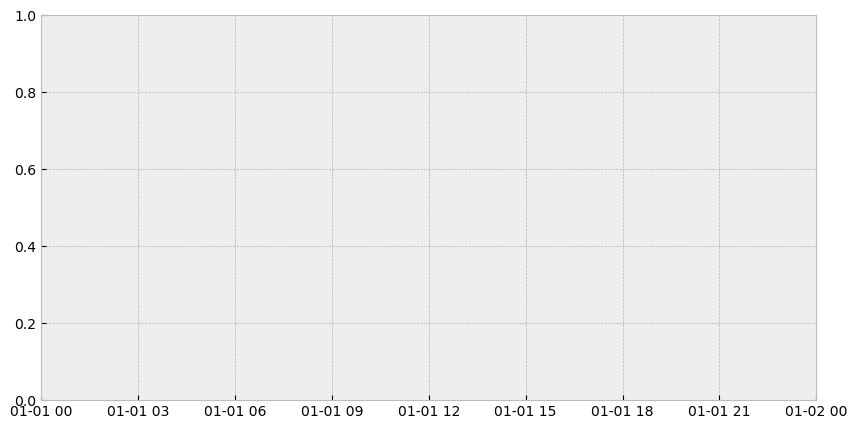

In [35]:
plot_classified_colormesh()

In [36]:
class_combination_mapping_corrected = {
    'clear & clear': 0,
    'low density & liquid_droplets': 1,
    'low density & snow': 2,
    'low density & ice_crystals': 3,
    'low density & graupel': 4,
    'precipitation & liquid_droplets': 5,
    'precipitation & snow': 6,
    'precipitation & ice_crystals': 7,
    'precipitation & graupel': 8,
    'clouds & liquid_droplets': 9,
    'clouds & snow': 10,
    'clouds & ice_crystals': 11,
    'clouds & graupel': 12
}

def classify_array(beta_attenuation, depolarization):
    # Define the classification thresholds
    depolarization_thresholds = {
        0 : [0, 0.2], # 'liquid_droplets
        1 : [0.2, 0.35], # 'snow'
        2 : [0.35, 0.5], # 'ice_crystals'
        3 : [0.5, 1] #'graupel'
    }

    beta_attenuation_thresholds = {
        0 : [1e-10, 1e-6], # 'clear'
        1 : [1e-6, 1e-5], # 'low density'
        5 : [1e-5, 5e-5], # 'precipitation'
        9 : [5e-5, 1e-3] # 'clouds
    }

    class_combination_mapping_corrected = {
    'clear & clear': 0,
    'low density & liquid_droplets': 1,
    'low density & snow': 2,
    'low density & ice_crystals': 3,
    'low density & graupel': 4,
    'precipitation & liquid_droplets': 5,
    'precipitation & snow': 6,
    'precipitation & ice_crystals': 7,
    'precipitation & graupel': 8,
    'clouds & liquid_droplets': 9,
    'clouds & snow': 10,
    'clouds & ice_crystals': 11,
    'clouds & graupel': 12
    }

    # Classify based on beta attenuation
    calssified_result_label = np.empty(beta_attenuation.shape)
    for label, (min_value, max_value) in beta_attenuation_thresholds.items():
        mask = (min_value <= beta_attenuation) & (beta_attenuation <= max_value)
        calssified_result_label[mask] = label

    # Classify based on depolarization
    for label, (min_value, max_value) in depolarization_thresholds.items():
        mask = (min_value <= depolarization) & (depolarization <= max_value)
        calssified_result_label[mask] += label

    calssified_result_label[np.isnan(beta_attenuation)] = np.nan

    return calssified_result_label

In [37]:
classification_result_june = classify_array(june.dataset['beta_att_clean'].T.values, june.dataset['linear_depol_ratio_clean'].T.values)

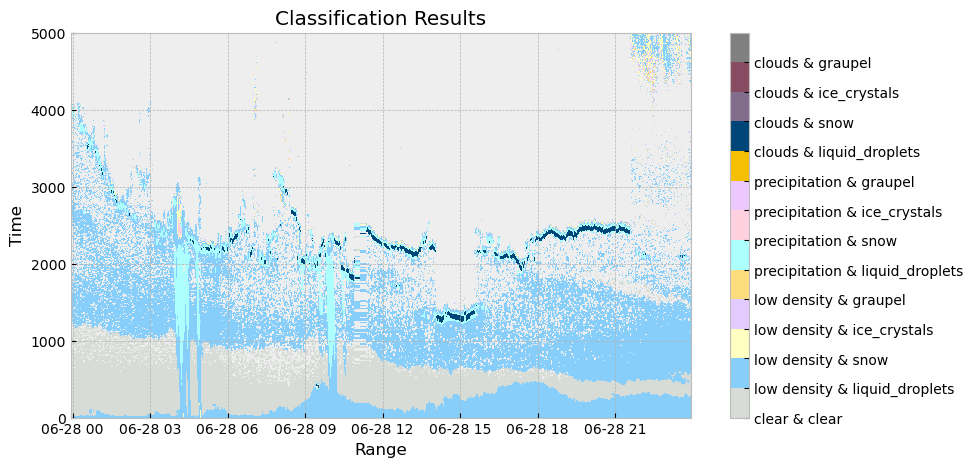

In [38]:
plot_classified_colormesh(classified_array=classification_result_june)

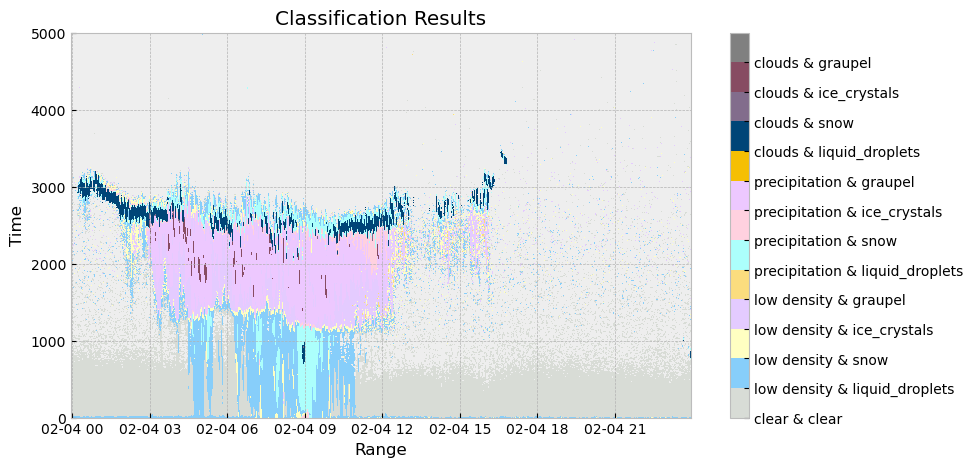

In [39]:
classification_result_feb = classify_array(februar_cl61.dataset['beta_att_clean'].T.values,
                                            februar_cl61.dataset['linear_depol_ratio_clean'].T.values)
plot_classified_colormesh(classified_array=classification_result_feb,
                          time_array=februar_cl61.dataset['time'])